In [34]:
#!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached flatbuffers-22.9.24-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.1

In [2]:
#!nvidia-smi

Sat Oct 15 02:15:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks, metrics

tf.get_logger().setLevel('INFO')
tf.__version__

'2.5.0'

In [2]:
# Check if GPU is available
if len(tf.config.list_physical_devices('GPU')) != 0:
    print(f"GPU available: {tf.test.gpu_device_name()}")
else:
    print("GPU unavailable")

GPU unavailable


In [3]:
# Load dataset
train_dir = "./dataset/train" 
val_dir = "./dataset/valid" 
test_dir = "./dataset/test"
train_dir ,val_dir, test_dir

('./dataset/train', './dataset/valid', './dataset/test')

In [4]:
# Set random seed to ensure reproducibility
tf.keras.utils.set_random_seed(42)

AttributeError: module 'tensorflow.keras.utils' has no attribute 'set_random_seed'

In [5]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
 batch_size=32,image_size=(224,224), seed=8)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
 batch_size=32,image_size=(224,224),seed=8)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
batch_size=32,image_size=(224,224),seed=8)

Found 13992 files belonging to 2 classes.
Found 3995 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [6]:
class_names = train_data.class_names
class_names

['0_non_bird', 'bird']

In [7]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 224, 224, 3)
[0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0]


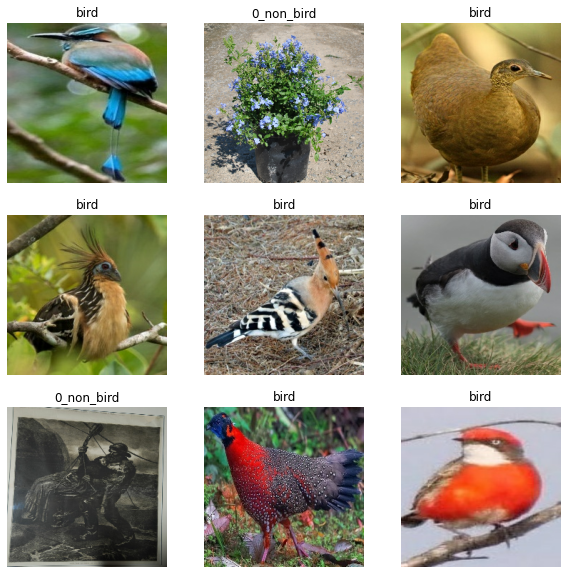

In [8]:
# Visualize training images
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]])
    plt.axis("off")


In [9]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [10]:
# Use base model from EfficientNetB0
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                      weights="imagenet",
                                      pooling='max',
                                      input_shape=input_shape)

# Make base model untrainable
base_model.trainable = False

# Build complete model
model0 = models.Sequential()
model0.add(base_model)
model0.add(layers.Dropout(rate=0.2))
model0.add(layers.Dense(units = 16, activation='relu'))
model0.add(layers.Dense(units = 1, activation='sigmoid'))
model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                20496     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 4,070,084
Trainable params: 20,513
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
model0.compile(optimizer='Adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

In [12]:
#Create early stopping call back
early_stopping = callbacks.EarlyStopping(patience=5, monitor='val_loss')

In [18]:
# Fit model
history = model0.fit(train_data, 
            epochs=20,
            validation_data=valid_data,
            callbacks=[early_stopping])

Epoch 1/20
310/310 [==============================] - 974s 3s/step - loss: 0.0842 - accuracy: 0.9742 - val_loss: 0.0152 - val_accuracy: 0.9955
Epoch 2/20
310/310 [==============================] - 103s 326ms/step - loss: 0.0329 - accuracy: 0.9904 - val_loss: 0.0144 - val_accuracy: 0.9958
Epoch 3/20
310/310 [==============================] - 103s 325ms/step - loss: 0.0219 - accuracy: 0.9941 - val_loss: 0.0139 - val_accuracy: 0.9970
Epoch 4/20
310/310 [==============================] - 103s 325ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.0342 - val_accuracy: 0.9891
Epoch 5/20
310/310 [==============================] - 104s 328ms/step - loss: 0.0254 - accuracy: 0.9937 - val_loss: 0.0147 - val_accuracy: 0.9960
Epoch 6/20
310/310 [==============================] - 102s 323ms/step - loss: 0.0170 - accuracy: 0.9947 - val_loss: 0.0112 - val_accuracy: 0.9965
Epoch 7/20
310/310 [==============================] - 102s 324ms/step - loss: 0.0190 - accuracy: 0.9942 - val_loss: 0.0127 - va

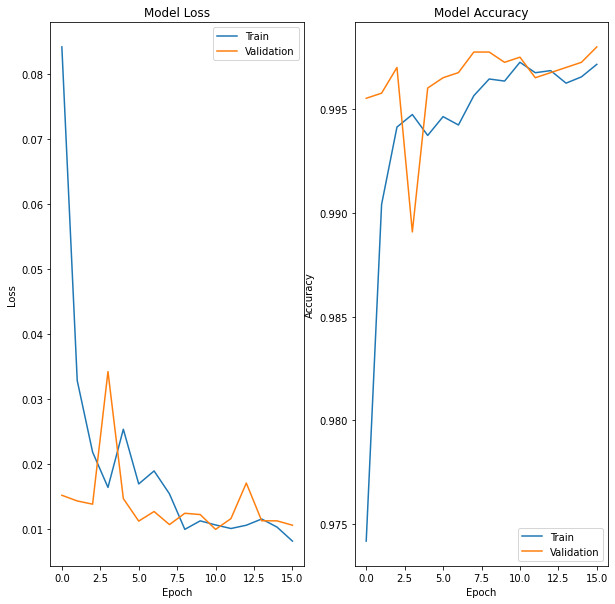

In [20]:
# Plot of loss and accuracy of training set and validation set
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.show()

In [21]:
# Model prediction
pred_prob = model0.predict(test_data)

def class_label(x):
  if x>=0.5:
    return 1
  else:
    return 0

pred_label = np.array(list(map(class_label, pred_prob)))

64/64 [==============================] - 15s 181ms/step


In [22]:
pred_prob[:10]

array([[9.9999416e-01],
       [2.4331410e-07],
       [8.0491676e-09],
       [9.9989414e-01],
       [6.1592856e-11],
       [9.8738343e-01],
       [1.0324922e-10],
       [1.2557228e-14],
       [9.9999988e-01],
       [9.4261289e-01]], dtype=float32)

In [23]:
pred_label[:10]

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 1])

In [24]:
loss, accuracy = model0.evaluate(test_data)
print(f"Model loss: {loss}")
print(f"Model accuracy: {accuracy*100: .2f}%")

64/64 [==============================] - 11s 155ms/step - loss: 0.0085 - accuracy: 0.9970
Model loss: 0.008454070426523685
Model accuracy:  99.70


In [25]:
# Visualizing prediction on test image
# Create a function to determine class label and confidence
def predict(model, img, class_label=class_label):
    image_array = tf.keras.preprocessing.image.img_to_array(img)
    image_array = tf.expand_dims(image_array, 0)

    predictions = model.predict(image_array).flatten()
    label = class_label(predictions)

    predicted_class = class_names[label]
    confidence = round((100 * predictions[0]), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


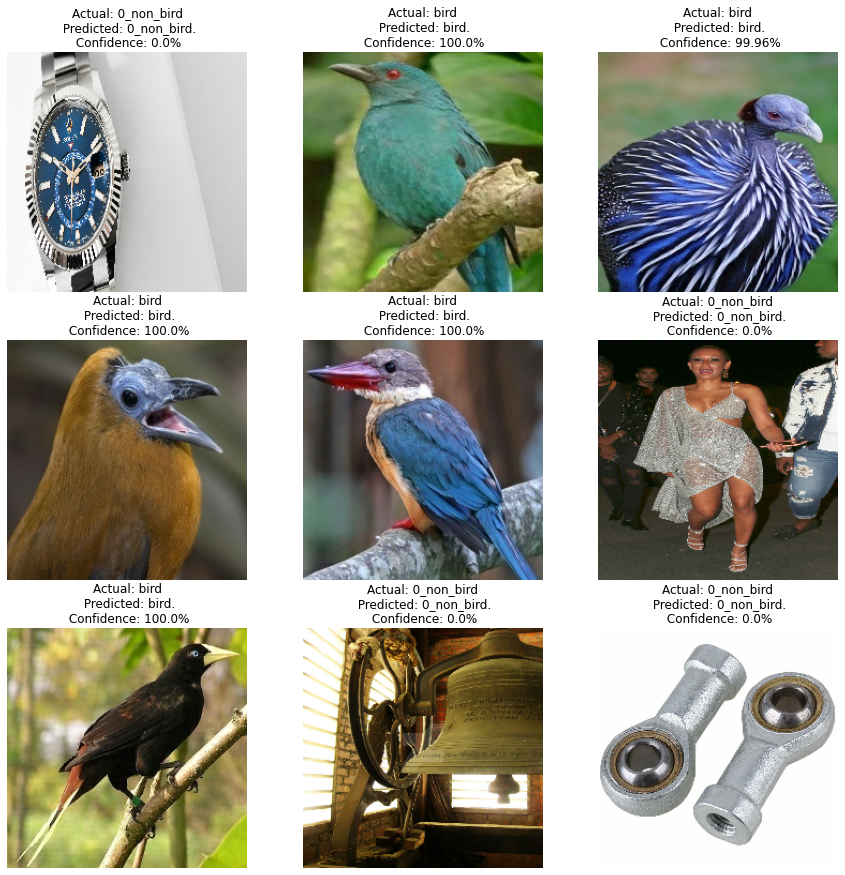

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model0, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [19]:
# Save Model
model_dir = './bidr_model1'
model0.save(model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bidr_model1/assets


In [30]:
# Convert model to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()

with open('./birdr_model1.tflite', 'wb') as f:
  f.write(tflite_model)